# Подготовка библиотек

In [1]:
# !pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /private/var/folders/6j/44cc_p1s7r7bkqgx8dw105zw0000gn/T/pip-req-build-vhjurzjs
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /private/var/folders/6j/44cc_p1s7r7bkqgx8dw105zw0000gn/T/pip-req-build-vhjurzjs
  Resolved https://github.com/tensorflow/examples.git to commit a09319553fd73de7152ed11e3ed56c72f35a91af
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a09319553fd73de7152ed11e3ed56c72f35a91af_-py3-none-any.whl size=299300 sha256=6849afe9b031a5072a01e07eee298cd9aaf21515ca79f7fcd1566ca49f576df6
  Stored in directory: /private/var/folders/6j/44cc_p1s7r7bkqgx8dw105zw0000gn/T/pip-ephem-wheel-cache-c_29d9mk/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed usin

In [3]:
# !pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 4.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=f6091e210674e8606c467738ff05bf534b0c313cd597f56c0a6141eb0acb5719
  Stored in directory: /Users/ildar/Library/Caches/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
Successfully built promise


In [4]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

import matplotlib.pyplot as plt

# Функции для визуализации

In [29]:
def display(display_list):
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [6]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

2022-07-08 11:27:21.092851: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


2022-07-08 11:41:06.067544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    input_mask = tf.math.round(input_mask)
    return input_image, input_mask

def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = dataset['train'].map(load_image_train)
test = dataset['test'].map(load_image_test)
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(BUFFER_SIZE)
test_dataset = test.batch(BATCH_SIZE)

sample_image, sample_mask = next(iter(train.take(1)))

In [40]:
train_dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [39]:
test_dataset

<BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>

In [10]:
print(TRAIN_LENGTH, info.splits['test'].num_examples)

3680 3669


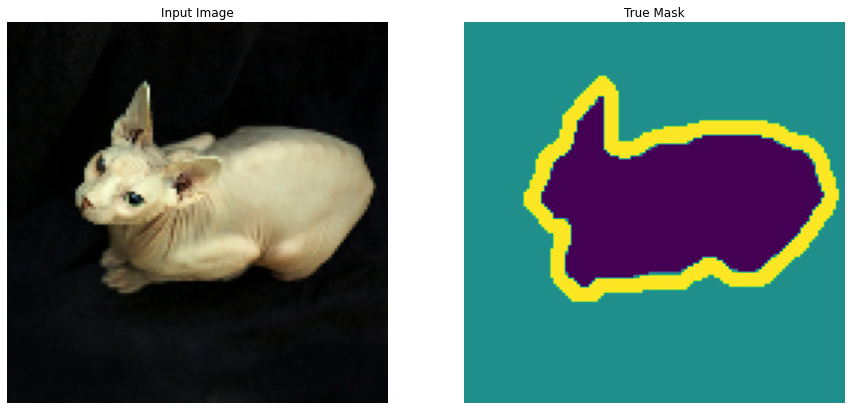

In [30]:
display([sample_image, sample_mask])

In [12]:
tf.unique(tf.reshape(sample_mask, -1))

Unique(y=<tf.Tensor: shape=(3,), dtype=float32, numpy=array([1., 2., 0.], dtype=float32)>, idx=<tf.Tensor: shape=(16384,), dtype=int32, numpy=array([0, 0, 0, ..., 0, 0, 0], dtype=int32)>)

# Модель

In [13]:
tf.random.set_seed(0)

Encoder (слои из преобученной модели MobileNetV2)

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


Decoder

In [15]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [18]:
def resolution_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [19]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

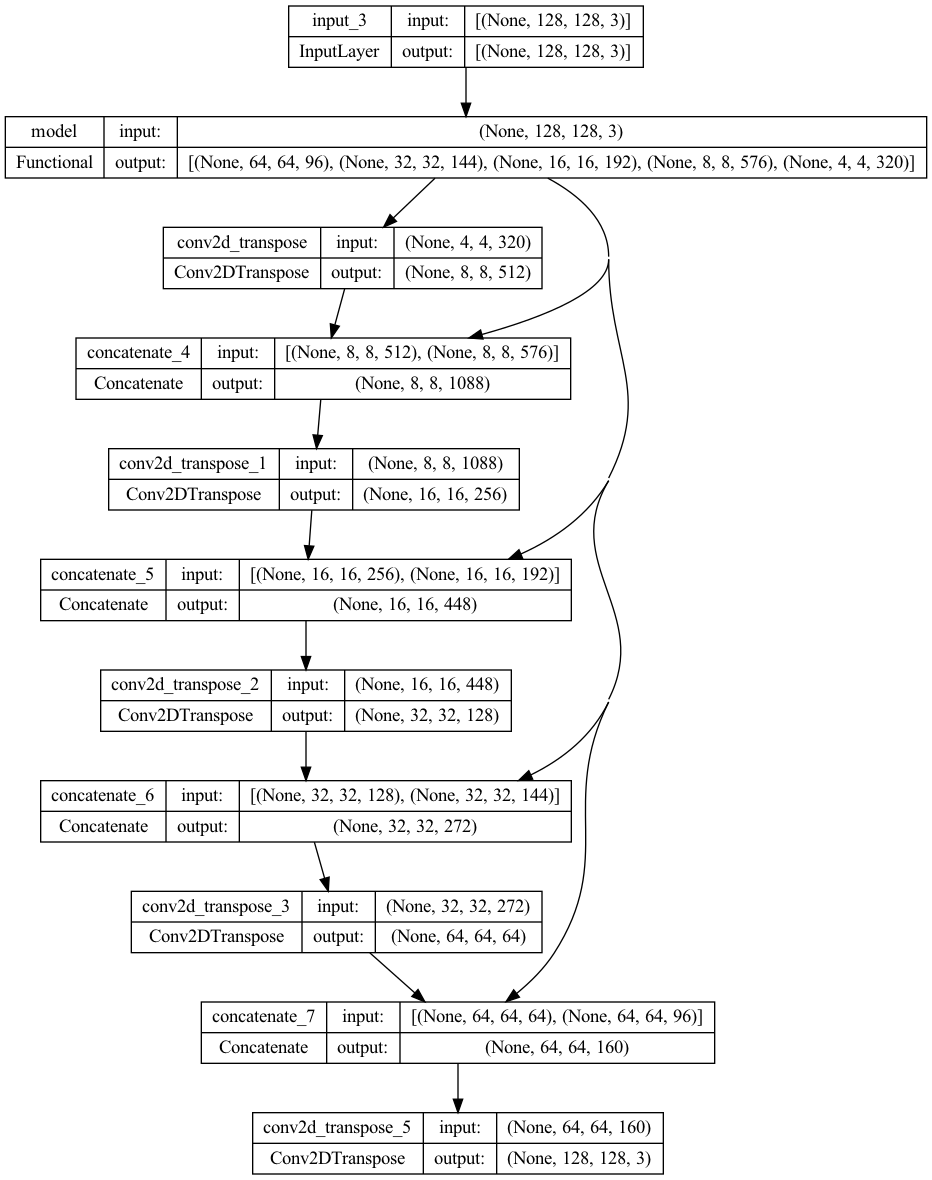

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 [==============================] - 1s 782ms/step


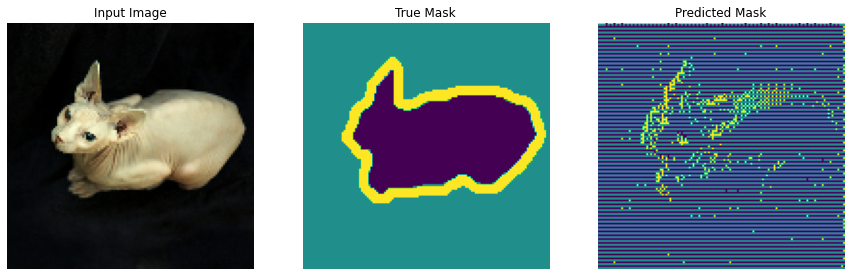

In [21]:
show_predictions(model)

# Обучение

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


1/1 [==============================] - 0s 35ms/step- loss: 0.5411 - accuracy: 0.77


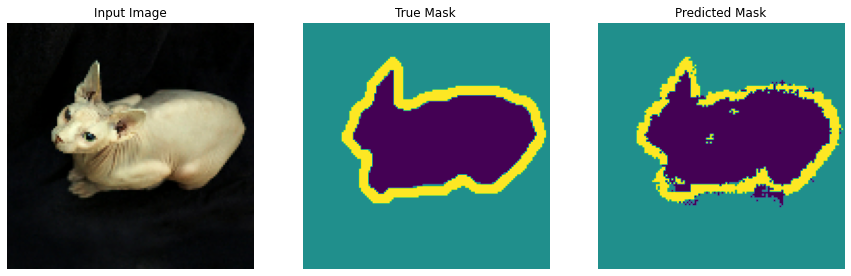


Sample Prediction after epoch 1

115/115 [==============================] - 145s 1s/step - loss: 0.5411 - accuracy: 0.7772 - val_loss: 0.3698 - val_accuracy: 0.8597
Epoch 2/10
1/1 [==============================] - 0s 35ms/step- loss: 0.3149 - accuracy: 0.87


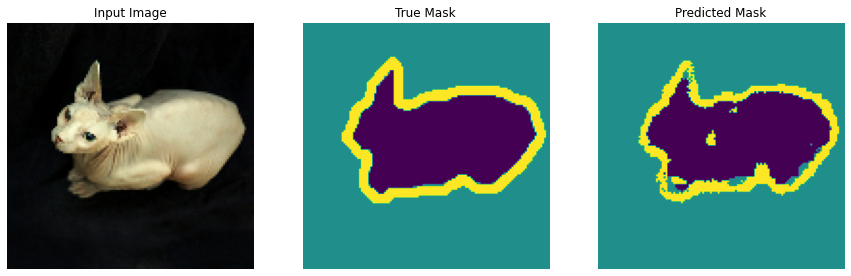


Sample Prediction after epoch 2

115/115 [==============================] - 145s 1s/step - loss: 0.3149 - accuracy: 0.8791 - val_loss: 0.3086 - val_accuracy: 0.8826
Epoch 3/10
1/1 [==============================] - 0s 43ms/step- loss: 0.2912 - accuracy: 0.88


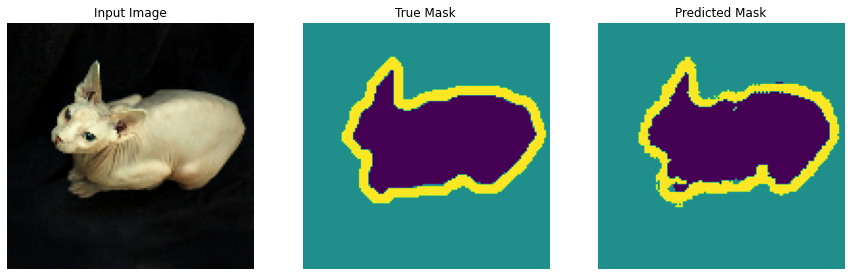


Sample Prediction after epoch 3

115/115 [==============================] - 159s 1s/step - loss: 0.2912 - accuracy: 0.8875 - val_loss: 0.2887 - val_accuracy: 0.8907
Epoch 4/10
1/1 [==============================] - 0s 37ms/step- loss: 0.2765 - accuracy: 0.89


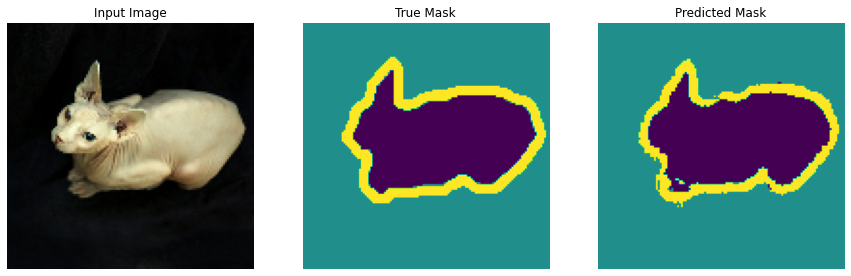


Sample Prediction after epoch 4

115/115 [==============================] - 168s 1s/step - loss: 0.2765 - accuracy: 0.8930 - val_loss: 0.2860 - val_accuracy: 0.8924
Epoch 5/10
1/1 [==============================] - 0s 48ms/step- loss: 0.2629 - accuracy: 0.89


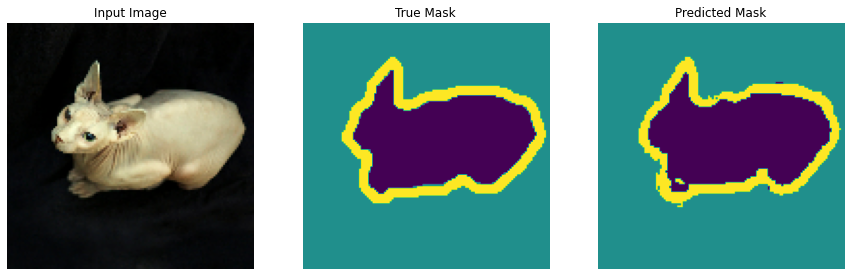


Sample Prediction after epoch 5

115/115 [==============================] - 163s 1s/step - loss: 0.2629 - accuracy: 0.8978 - val_loss: 0.2770 - val_accuracy: 0.8959
Epoch 6/10
1/1 [==============================] - 0s 35ms/step- loss: 0.2527 - accuracy: 0.90


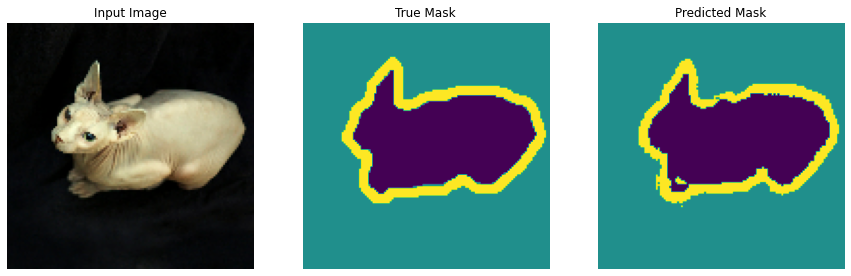


Sample Prediction after epoch 6

115/115 [==============================] - 179s 2s/step - loss: 0.2527 - accuracy: 0.9018 - val_loss: 0.2767 - val_accuracy: 0.8953
Epoch 7/10
1/1 [==============================] - 0s 57ms/step- loss: 0.2462 - accuracy: 0.90


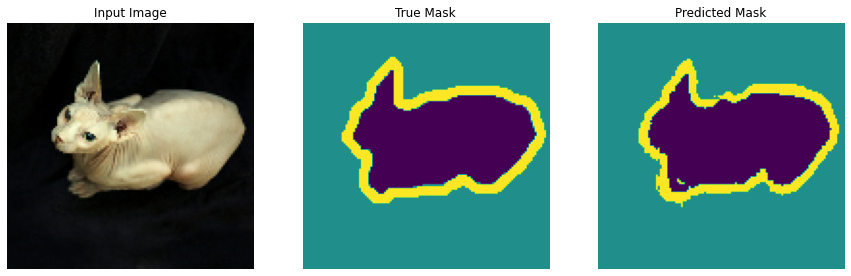


Sample Prediction after epoch 7

115/115 [==============================] - 161s 1s/step - loss: 0.2462 - accuracy: 0.9039 - val_loss: 0.2786 - val_accuracy: 0.8973
Epoch 8/10
1/1 [==============================] - 0s 36ms/step- loss: 0.2370 - accuracy: 0.90


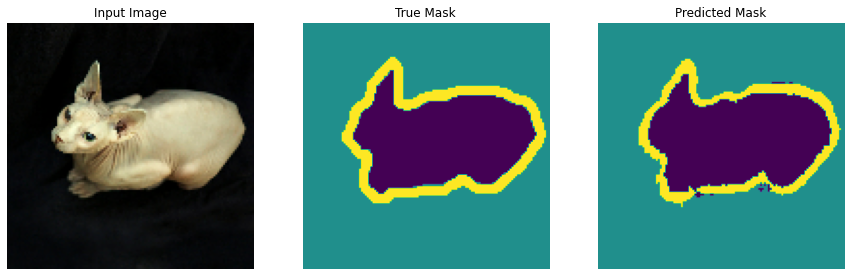


Sample Prediction after epoch 8

115/115 [==============================] - 158s 1s/step - loss: 0.2370 - accuracy: 0.9075 - val_loss: 0.2788 - val_accuracy: 0.8969
Epoch 9/10
1/1 [==============================] - 0s 37ms/step- loss: 0.2300 - accuracy: 0.91


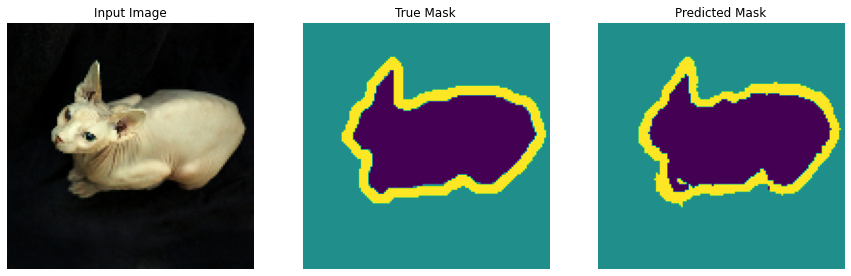


Sample Prediction after epoch 9

115/115 [==============================] - 161s 1s/step - loss: 0.2300 - accuracy: 0.9101 - val_loss: 0.2720 - val_accuracy: 0.8996
Epoch 10/10
1/1 [==============================] - 0s 36ms/step- loss: 0.2222 - accuracy: 0.91


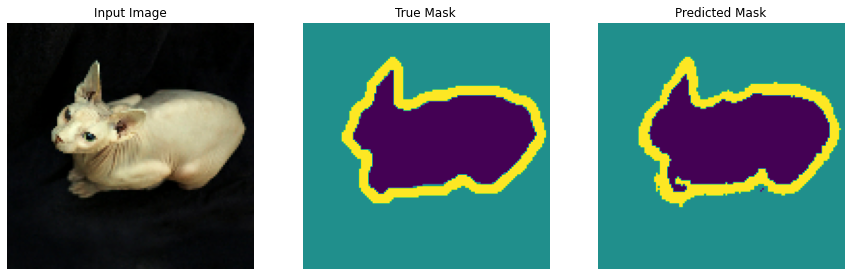


Sample Prediction after epoch 10

115/115 [==============================] - 175s 2s/step - loss: 0.2222 - accuracy: 0.9129 - val_loss: 0.2700 - val_accuracy: 0.8993


In [22]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions(model)
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 10 # увеличьте при необходимости

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

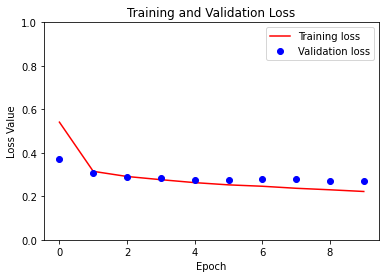

In [25]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

1/1 [==============================] - 0s 480ms/step


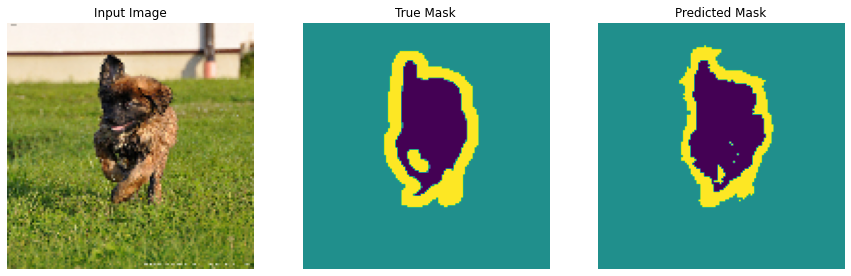

1/1 [==============================] - 0s 488ms/step


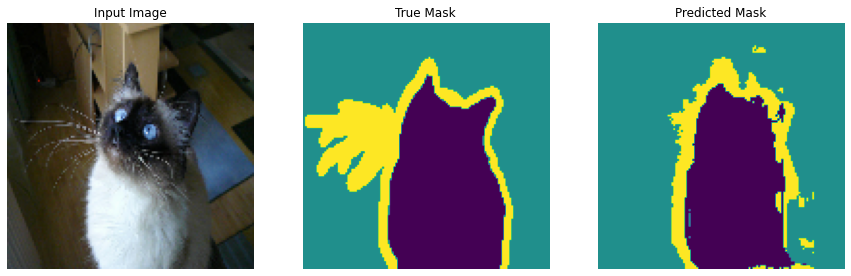

1/1 [==============================] - 0s 432ms/step


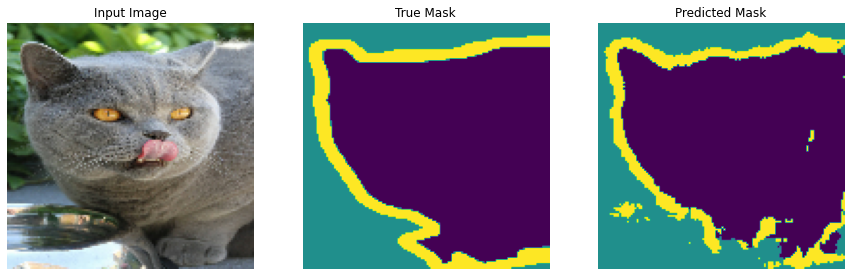

In [26]:
show_predictions(model, test_dataset, 3)